In [2]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import pandas as pd
from matplotlib.lines import Line2D

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


# Map of training data

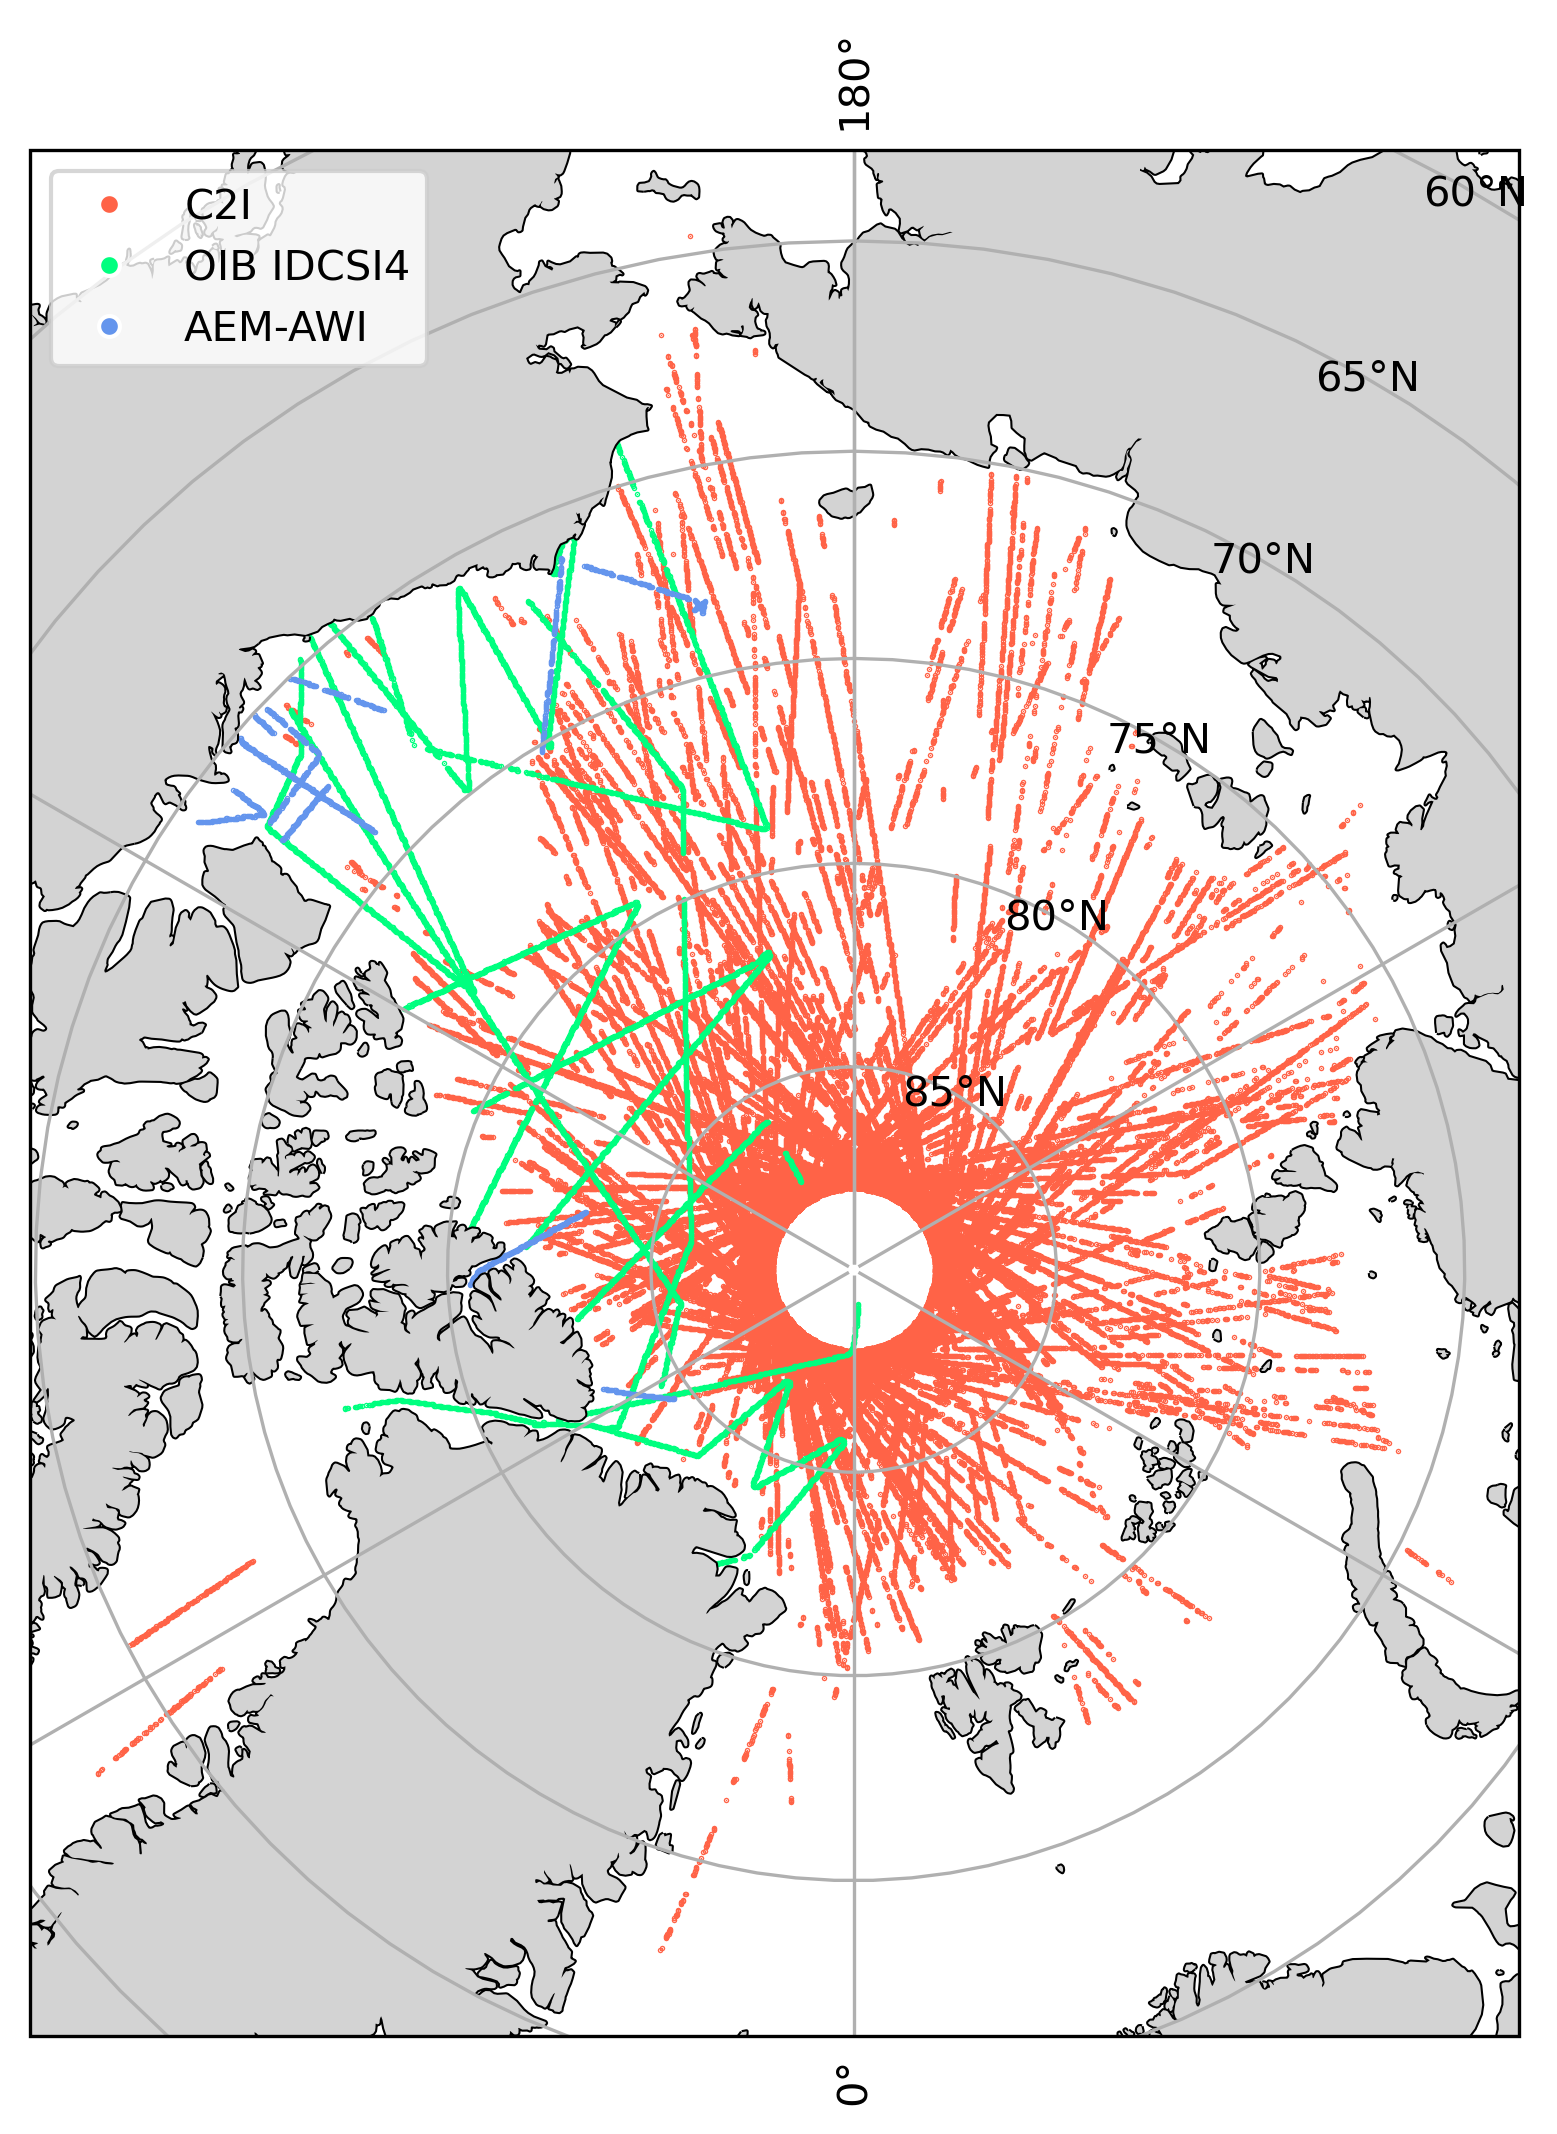

In [9]:
full_data_path = "data/intermediate/datasets_final/LARM_smoothed/EASE2.0_N3.125km/ASTD_v1.0-N3.125km-LARM_smoothed.parquet"
df = pd.read_parquet(full_data_path)
df = df.dropna(subset=['36H'])
df = df[df['secondary_id']!='QuickLook']

fig = plt.figure(figsize=(7,7), layout='constrained',dpi=300)
color_map = {0: "tomato", 1: "springgreen", 2: "cornflowerblue"}
categories = pd.factorize(df['primary_id'])[0]

ax = fig.add_subplot(1,1,1, projection = ccrs.NorthPolarStereo(central_longitude=0))
for cat in color_map:
    xs = np.array([df['lon'].values.squeeze()[i] for i in range(len(df['x'])) if categories[i] == cat])
    ys = np.array([df['lat'].values.squeeze()[i] for i in range(len(df['y'])) if categories[i] == cat])
    ax.scatter(xs, ys, c=color_map[cat], label=cat, transform=ccrs.PlateCarree(), s=0.1)

legend_elements = [
    Line2D([0], [0], marker='.', color="w", markerfacecolor="tomato", markersize=10, linestyle='None', label="C2I"),
    Line2D([0], [0], marker='.', color="w", markerfacecolor="springgreen", markersize=10, linestyle='None', label="OIB IDCSI4"),
    Line2D([0], [0], marker='.', color="w", markerfacecolor="cornflowerblue", markersize=10, linestyle='None', label="AEM-AWI"),
]

# Apply custom legend
ax.legend(handles=legend_elements, loc="upper left")
ax.coastlines()
land_feature = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', facecolor='lightgray')
ax.add_feature(land_feature)
ax.gridlines(draw_labels=True)
fig.savefig('./data/fig/SD_measures.png', dpi=300)

# Illustrate data distributions

In [11]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor
import src.data_src.point_data_sources as pds
from src.utils.grid_utils import Grid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

grid = Grid.from_predefined('EASE2_N12.5km')


raw_C2I_LARM = pd.concat([
    pds.C2I('./data/raw/C2I_SnowDepths/CRYO2ICE_individul_comparison_BaselineE/2020-2021', secondary_id='2020-2021', retracker='LARM').get_preprocessed_SD_df(),
    pds.C2I('./data/raw/C2I_SnowDepths/CRYO2ICE_individul_comparison_BaselineE/2021-2022', secondary_id='2021-2022', retracker='LARM').get_preprocessed_SD_df()
])
raw_C2I_LARM_smoothed = pd.concat([
    pds.C2I('./data/raw/C2I_SnowDepths/CRYO2ICE_individul_comparison_BaselineE/2020-2021', secondary_id='2020-2021', retracker='LARM_smoothed').get_preprocessed_SD_df(),
    pds.C2I('./data/raw/C2I_SnowDepths/CRYO2ICE_individul_comparison_BaselineE/2021-2022', secondary_id='2021-2022', retracker='LARM_smoothed').get_preprocessed_SD_df()
])

raw_OIB = pds.OIB_IDCSI4('./data/raw/OIB_IDCSI4').get_preprocessed_SD_df()

raw_AEM_AWI = pd.concat([
    pds.AEM_AWI_ICEBIRD('./data/raw/AEM-AWI-ICEBIRD_2019/datasets').get_preprocessed_SD_df(),
    pds.AEM_AWI_PAMARCMIP('./data/raw/AEM-AWI-PAMARCMIP_2017/datasets').get_preprocessed_SD_df()
])

gridded_data_LARM = pds.GriddedPointDataSource.load('./data/intermediate/datasets/EASE2_LARM_N12.5km_v1.1/ASP_full.parquet', grid=grid).data
gridded_data_LARM_smoothed = pds.GriddedPointDataSource.load('./data/intermediate/datasets/EASE2_LARM-smoothed_N12.5km_v1.1/ASP_full.parquet', grid=grid).data

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


In [ ]:
raw_data = raw_C2I_LARM
print('Count:   ', len(raw_data))
print('min:     ', round(raw_data['snow_depth'].min()*100, 2))
print('mean:    ', round(raw_data['snow_depth'].mean()*100, 2))
print('median:    ', round(raw_data['snow_depth'].median()*100, 2))
print('max:     ', round(raw_data['snow_depth'].max()*100, 2))
print('std:     ', round(raw_data['snow_depth'].std()*100, 2))
print('MAD:     ', round(np.mean(np.abs(raw_data['snow_depth'] - raw_data['snow_depth'].mean()).mean()*100), 2))


Count:    328967
min:      0.0
mean:     17.88
median:     16.95
max:      79.08
std:      9.37
MAD:      7.52


In [ ]:
min_samples = 10
primary_id = 'C2I'

####
cdata = gridded_data_LARM[gridded_data_LARM['primary_id'] == primary_id]
cdata = cdata.dropna(subset=['SD_mean'])

print(f"Statistics for gridded {primary_id} with min samples {min_samples}:")
print('Count:   ', len(cdata))
cdata = cdata[cdata['num_samples']>=min_samples]
print('min:     ', round(cdata['SD_mean'].min()*100, 2))
print('mean:    ', round(cdata['SD_mean'].mean()*100, 2))
print('max:     ', round(cdata['SD_mean'].max()*100, 2))
print('std:     ', round(cdata['SD_mean'].std()*100, 2))
print('std mean:', round(cdata['SD_std'].mean()*100, 2))

Statistics for gridded C2I with min samples 10:
Count:    28459
min:      2.54
mean:     17.96
max:      52.92
std:      5.95
std mean: 7.23


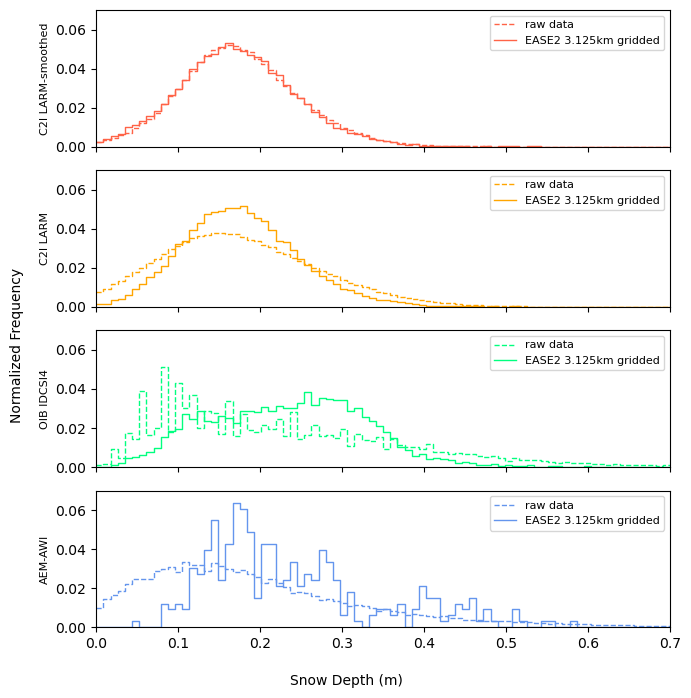

In [13]:
def hist_outlined(ax, val, bins, data_range, normalize, linestyle, color, **kwargs):
    """
    Standard histogram but with only outline drawn.
    """
    if type(val) == np.ndarray:
        val = [val]
    elif type(val) != list:
        raise ValueError('Wrong input type for val')

    x = []
    y = []
    for v in val:
        # Compute histogram
        counts, bin_edges = np.histogram(v, bins=bins, range=data_range)
        if normalize:
            counts = counts.astype(float)/np.sum(counts).astype(float)
        
        # Duplicate edges for stepwise plotting
        x.append(np.repeat(bin_edges, 2)[1:-1])
        y.append(np.repeat(counts, 2))
    
    # Plot as a line
    h = ax.plot(np.stack(x,axis=1), np.stack(y,axis=1), linestyle=linestyle, color=color, **kwargs)
    ax.set_xlim(data_range)
    ax.set_ylim(0)
    return h

color = ["tomato", 'orange', "springgreen", "cornflowerblue"]
formats = ['--', '-']
ids = ['C2I LARM-smoothed','C2I LARM','OIB IDCSI4','AEM-AWI']

datasets = [
    (raw_C2I_LARM_smoothed['snow_depth'].values,     gridded_data_LARM_smoothed[gridded_data_LARM_smoothed['primary_id'] == 'C2I']['SD_mean'].values),
    (raw_C2I_LARM['snow_depth'].values,     gridded_data_LARM[gridded_data_LARM['primary_id'] == 'C2I']['SD_mean'].values),
    (raw_OIB['snow_depth'].values,     gridded_data_LARM_smoothed[gridded_data_LARM_smoothed['primary_id'] == 'OIB']['SD_mean'].values),
    (raw_AEM_AWI['snow_depth'].values, gridded_data_LARM_smoothed[gridded_data_LARM_smoothed['primary_id'] == 'AEM_AWI']['SD_mean'].values),
]



fig, ax = plt.subplots(4,1, figsize=(7,7), sharex=True, tight_layout=True)
for i, dataset in enumerate(datasets):
    cax = ax[i]
    for j, format in enumerate(formats):
        h = hist_outlined(cax, dataset[j], bins=80, data_range=(0,0.7), normalize=True, linestyle=format, color=color[i], lw=1)
    cax.set_ylabel(ids[i],fontsize=8)
    cax.set_ylim(0,0.07)
    cax.legend(['raw data', 'EASE2 3.125km gridded'],fontsize=8)
fig.supylabel('Normalized Frequency',fontsize=10)
fig.supxlabel('Snow Depth (m)',fontsize=10)

fig.savefig('./data/fig/snow_depth_comparison.pdf')

# Illustrate input channels

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


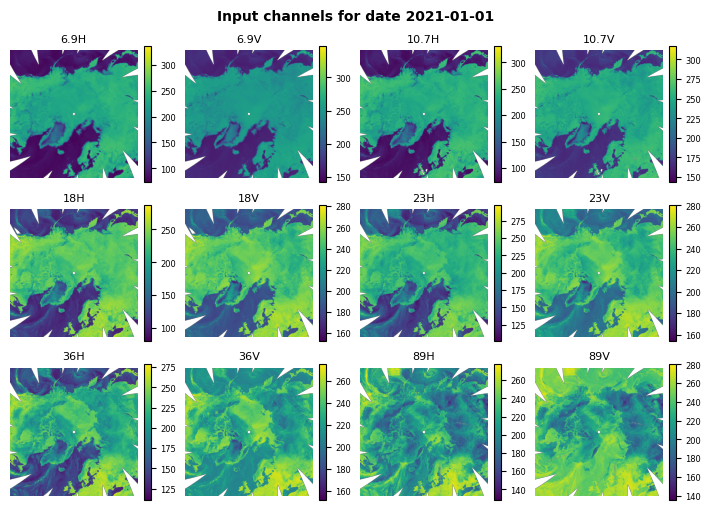

In [ ]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor
import matplotlib.pyplot as plt
import pandas as pd
from src.utils.grid_utils import Grid
from src.utils.data_utils import DataMapping
from src.data_src.gridded_data_sources import load_ERA5_data, load_CETB_data

date = pd.Timestamp('2021-01-01')

target_grid = Grid.from_predefined('EASE2_N12.5km')
target_grid.modify_extent([-4500000,-4500000,4500000,4500000])

cetb_channels =['6.9H','6.9V',
                '10.7H','10.7V',
                '18H','18V',
                '23H','23V',
                '36H','36V',
                '89H','89V']

#era5_channels = [ 't2m', 'tclw', 'tcwv', 'siconc']

cetb_mapping = DataMapping("./data/raw/CETB_AMSR2", 'CETB')
#era5_mapping = DataMapping("./data/raw/ERA5_all-param_daily_perMonth_1hourly-sample", 'ERA5')        
# Identify available data for given date
cetb_data = cetb_mapping.get_by_date(date)
#era5_data = era5_mapping.get_by_date(date)


# loading data
cetb_data = cetb_data[cetb_data['channel'].isin(cetb_channels)]
cetb_scene = load_CETB_data(cetb_data['filename'], grid=target_grid)        
#era5_data = era5_data[era5_data['channel'].isin(era5_channels)]
#era5_scene = load_ERA5_data(era5_data['filename'], grid=target_grid)

# merging data
scene = cetb_scene #+ era5_scene

channels = cetb_channels #+ era5_channels

fig, ax = plt.subplots(3,4, figsize=(7,5), layout='constrained')
ax = ax.flatten()
for i, channel in enumerate(channels):
    im = ax[i].imshow(scene.data[channel][0], cmap='viridis')
    cb =fig.colorbar(im, ax=ax[i])
    cb.ax.tick_params(labelsize=6)
    ax[i].set_title(channel, fontsize=8)
    ax[i].axis('off')
fig.suptitle(f'Input channels for date {date.date()}', fontsize=10, fontweight='bold')
fig.savefig('./data/fig/input_channels_example.pdf')

# Latitude weight

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


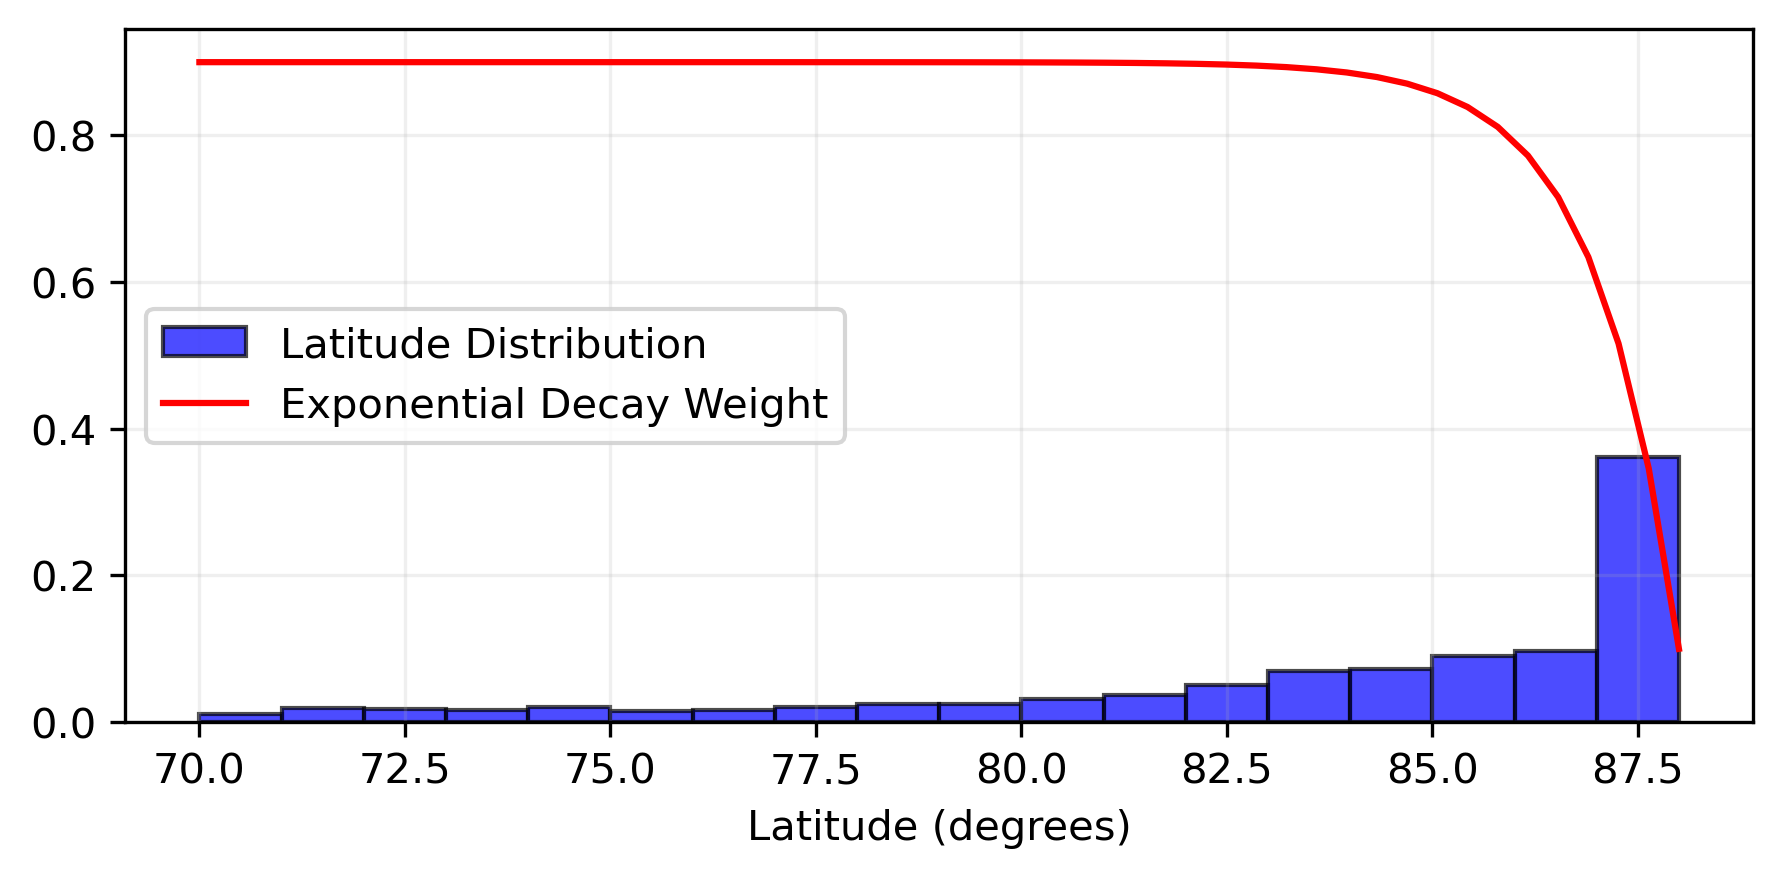

In [ ]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_parquet(r'data\intermediate\datasets\EASE2_LARM-smoothed_N3.125km_v1.1\ASP_train.parquet')

plt.figure(figsize=(7,3), dpi=300)
# make frequency histogram of latitudes
plt.hist(df['lat'], bins=18, color='blue', alpha=0.7, edgecolor='black',density=True,range=(70,88), label='Latitude Distribution')

x = np.linspace(70,88)
y = 0.9 - 0.8 * np.exp((x-70))/np.exp(18)
plt.plot(x,y, label='Exponential Decay Weight', color='red')

plt.xlabel('Latitude (degrees)')
#plt.ylabel('Normalized Frequency')
#plt.title('Latitude Distribution with Exponential Decay weighting')
plt.legend(loc='center left')
plt.grid(alpha=0.2)
plt.savefig(r'data\fig\latitude_distribution_with_exponential_decay_weighting.pdf', dpi=300, bbox_inches='tight')
plt.show()